In [18]:
import torch
import torch.cuda
import torch.optim as optim
# import torch.cuda as torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pickle as pkl
import os

import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

cuda = True

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform(m.weight, gain=0.5)
        nn.init.constant(m.bias, 0) 
    else:
        nn.init.normal(m.weight)

In [19]:
class Prediction(nn.Module):
    """Prediction (Ahat) module
    Equals:
    SatLU(ReLU(Conv(input))) if layer = 0
    ReLU(Conv(input)) if layer > 0
    """
    def __init__(self, layer, inputChannels, outputChannels, filterSize,
                 pixel_max=1.):
        super(Prediction, self).__init__()
        self.layer = layer
        self.pixel_max = pixel_max
        self.conv = nn.Conv2d(inputChannels, outputChannels, filterSize, padding=(filterSize-1)//2)
        weights_init(self.conv)
        self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()
           
        
    def forward(self, x_in):
#         print("layer: {} prediction_in: {}".format(self.layer, x_in.shape))
        x = self.conv(x_in)
        #x = self.sigmoid(x) # Do this instead of clamping
        x = self.relu(x)
        if self.layer == 0:
            x = torch.clamp(x, max=self.pixel_max)
#         print("layer: {}\n\tprediction_in: {}\n\tprediction_out: {}".format(self.layer, x_in.shape, x.shape))
        return x



#pred = Prediction(1, 3, 6, 3)
#weights_init(pred.conv)
#print(pred.conv.bias)


In [20]:
class Target(nn.Module):
    """Target (A) module
    Equals:
    input (x) if layer = 0
    MaxPool(ReLU(Conv(input))) if layer > 0 
    """
    def __init__(self, layer, inputChannels, outputChannels, filterSize):
        super(Target, self).__init__()
        self.layer = layer
        self.conv = nn.Conv2d(inputChannels, outputChannels, filterSize, padding=(filterSize-1)//2)
        self.maxpool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        weights_init(self.conv)
    
    def forward(self, x_in):
        if self.layer > 0:
            x = self.conv(x_in)
            x = self.relu(x)
            x_out = self.maxpool(x)
#         print("layer: {}\n\ttarget_in: {}\n\ttarget_out: {}".format(self.layer, x_in.shape, x.shape))
            return x_out
        else:
            return x_in

In [21]:
class Error(nn.Module):
    """Error (E) module
    Input
    -----
    Images Ahat and A to be compared. Must have same number of channels.
    
    
    Output
    ------
    [ReLU(Ahat - A); ReLU(A - Ahat)]
    where concatenation is performed along the channel (feature) dimension.
    """
    def __init__(self, layer):
        super(Error, self).__init__()
        self.layer = layer
        self.relu = nn.ReLU()
        
    def forward(self, prediction, target):
#         print(target.shape)
#         print(prediction.shape)
        d1 = self.relu(target - prediction)
        d2 = self.relu(prediction - target)

        x = torch.cat((d2, d1), -3)
#         print("layer: {}\n\terror_in (x2): {}\n\terror_out: {}".format(self.layer, prediction.shape, x.shape))
        return x

In [22]:
# Representation Module Utility
class HardSigmoid(nn.Module):
    """
    Re-implementation of HardSigmoid from Theano. (Rolfo, Nishimura 2017)
    
    Constrained to be 0 when x <= min_val and
    1 when x >= max_val, 
    and to be linear in between the two ranges.
    """
    def __init__(self, min_val, max_val):
        super(HardSigmoid, self).__init__()
        self.min_val = min_val
        self.max_val = max_val
        self.hardtanh = nn.Hardtanh(min_val, max_val)
    def forward(self, x_in):
        x = self.hardtanh(x_in)
        x = (x - self.min_val)/(self.max_val - self.min_val)
        return x

# m = (nn.Hardtanh(-2.5,2.5) + torch.Tensor(2.5))/5
# m = HardSigmoid(-2.5, 2.5)
# x = torch.autograd.Variable(torch.randn(2))
# print(x)
# print(m(x))


In [23]:
class Representation(nn.Module):
    """Representation (R) module
    
    A ConvLSTM (https://arxiv.org/pdf/1506.04214.pdf) unit.
    
    Actually, it's implemented differently in the prednet paper,
    so we decided to mimic that implementation as much as possible.
    """
    def __init__(self, layer, numLayers, 
                 R_stack_sizes, A_stack_sizes,
                 kernel_size,
                 c_height_width=None,
                 peephole=True, hardsigmoid_min=-2.5, hardsigmoid_max=2.5):
        
        # keras: Conv2D(filters aka out_channels, kernel_size, strides=(1, 1), padding='valid', data_format=None
        # KERAS: Conv2D(self.R_stack_sizes[l], self.R_filt_sizes[l], padding='same', activation=act, data_format=self.data_format))
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        
        # in_channels -> Lotter. should be self.R_stack_sizes[l] + e_stack_sizes[l] + if(not last) R_stack_sizes[l+1]
        # out_channels -> Lotter self.R_stack_sizes[l], 
        # kernel_size -> Lotter self.R_filt_sizes[l]. all 3s
        super(Representation, self).__init__()
        self.layer = layer
        self.numLayers = numLayers
        self.peephole = peephole
        
        ### Keep track of sizes of inputs ###
        inputChannels = {}
        self.E_stack_sizes = tuple(2*stack_size for stack_size in A_stack_sizes)
        self.C_stack_size = R_stack_sizes[layer] # the cell size for this layer
        if (layer == numLayers-1):
            for gate in ['i', 'f', 'o']:
                inputChannels[gate] = R_stack_sizes[layer] + self.E_stack_sizes[layer]
        else:
            for gate in ['i', 'f', 'o']:
                inputChannels[gate] = R_stack_sizes[layer] + self.E_stack_sizes[layer] + R_stack_sizes[layer+1]
        ### END ###
            
        if peephole:
#             self.Wc = {} # Parameters for hadamard (elementwise) products
#             for gate in ['i', 'f', 'o']:
#                 self.Wc[gate] = torch.Parameter(torch.FloatTensor(inputChannels['c'], c_width_height[0], c_width_height[1]))
            self.Wc_i = nn.Parameter(torch.FloatTensor(R_stack_sizes[layer], c_height_width[0], c_height_width[1]), requires_grad=True)
            self.Wc_f = nn.Parameter(torch.FloatTensor(R_stack_sizes[layer], c_height_width[0], c_height_width[1]), requires_grad=True)
            self.Wc_o = nn.Parameter(torch.FloatTensor(R_stack_sizes[layer], c_height_width[0], c_height_width[1]), requires_grad=True)
            weights_init(self.Wc_i)
            weights_init(self.Wc_f)
            weights_init(self.Wc_o)
#         self.conv = {}
#         self.act = {}
        outputChannels = R_stack_sizes[layer]
#         for gate in ['i', 'f', 'o', 'c']:
#             print((kernel_size-1)/2)
#             self.conv[gate] = nn.Conv2d(inputChannels[gate], outputChannels, kernel_size, padding=(kernel_size-1)//2)

        self.conv_i = nn.Conv2d(inputChannels[gate], outputChannels, kernel_size, padding=(kernel_size-1)//2)
        self.conv_f = nn.Conv2d(inputChannels[gate], outputChannels, kernel_size, padding=(kernel_size-1)//2)
        self.conv_o = nn.Conv2d(inputChannels[gate], outputChannels, kernel_size, padding=(kernel_size-1)//2)
        self.conv_c = nn.Conv2d(inputChannels[gate], outputChannels, kernel_size, padding=(kernel_size-1)//2)

        weights_init(self.conv_i)
        weights_init(self.conv_f)
        weights_init(self.conv_o)
        weights_init(self.conv_c)
        
#         self.act['i'] = HardSigmoid(hardsigmoid_min, hardsigmoid_max)
#         self.act['f'] = HardSigmoid(hardsigmoid_min, hardsigmoid_max)
#         self.act['o'] = HardSigmoid(hardsigmoid_min, hardsigmoid_max)
#         self.act['c'] = nn.Tanh()
#         self.act['h'] = nn.Tanh()
        self.act_i = HardSigmoid(hardsigmoid_min, hardsigmoid_max)
        self.act_f = HardSigmoid(hardsigmoid_min, hardsigmoid_max)
        self.act_o = HardSigmoid(hardsigmoid_min, hardsigmoid_max)
        self.act_c = nn.Tanh()
        self.act_h = nn.Tanh()
        
        # Upsampling
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        
        
        
    def forward(self, e_prev, r_prev, c_prev, r_above):
        """
        e_prev: the error input at (l, t-1)
        r_prev: the input to ahat of the representation cell at (l, t-1)
        c_prev: the cell (internal) of the representation cell at (l, t-1)
        r_above: the input to ahat of the rep.cell at (l+1, t) -- to ignore if l = L
        
        # Lotter implementation, which is bastardized CLSTM
        """

        stacked_inputs = torch.cat((r_prev, e_prev), -3)
        if (self.layer < self.numLayers-1):
            r_above_up = self.upsample(r_above)
            stacked_inputs = torch.cat((stacked_inputs, r_above_up), -3)
        
        # Calculate hidden cell update:
        # First get gate updates
#         gates = {}
#         for gate in ['i', 'f', 'o']:
#             gates[gate] = self.conv[gate](stacked_inputs)
#         if self.peephole:
#             gates['f'] += torch.mul(self.Wc['f'], c_prev)
#             gates['i'] += torch.mul(self.Wc['i'], c_prev)

        # Compute gates
        i = self.conv_i(stacked_inputs)
        f = self.conv_f(stacked_inputs)
        o = self.conv_o(stacked_inputs)
        if self.peephole:
#             print(f.shape)
#             print(self.Wc_f.shape)
            f = f + self.Wc_f * c_prev
            i = i + self.Wc_i * c_prev
        i = self.act_i(i)
        f = self.act_f(f)
            


        # Update hidden cell
#         print('gates f', gates['f'].shape)
#         print('gates i', gates['i'].shape)
#         print('gates o', gates['o'].shape)
#         print('stacked inputs', stacked_inputs.shape)
#         print('cprev', c_prev.shape)
#         print(c_prev.shape)
#         print(stacked_inputs.shape)
#         print(gates['f'].shape)
#         print("layer: {}\n\tr_in: {}\n\tr_out: {} \
#               \n\tc_in: {}\n\tc_out: {}\n\terror".format(self.layer, 
#                                                                         r_prev.shape, r.shape,
#                                                                         c_prev.shape, c.shape,
#                                                                         e_prev.shape))
#         c = gates['f'] * c_prev + gates['i'] * \
#             self.act['c'](self.conv['c'](stacked_inputs))

        # Update hidden cell
        c = f * c_prev + i * self.act_c(self.conv_c(stacked_inputs))
    
        # o gate uses current cell, not previous cell
        if self.peephole:
            o = o + self.Wc_o * c
        o = self.act_o(o)


#         r = torch.mul(gates['o'], self.act['c'](c))
        r = o * self.act_h(c)
#         print(r.shape)
        
#         print("layer: {}\n\tr_in: {}\n\tr_out: {} \
#               \n\tc_in: {}\n\tc_out: {}\n\terror".format(self.layer, 
#                                                                         r_prev.shape, r.shape,
#                                                                         c_prev.shape, c.shape,
#                                                                         e_prev.shape))
        return r, c

In [24]:
class PredNet(nn.Module):
    """Full stack of layers in the prednet architecture
    |targets|, |errors|, |predictions|, and |representations|
    are all lists of nn.Modules as defined in their respective class
    definitions.
    
    If the prednet has L prednet layers, then
    targets has length L-1
    errors, predictions, and representations have length L
    
    """
    def __init__(self, targets, errors, 
                 predictions, representations,
                 numLayers, R_stack_sizes, stack_sizes, heights, widths):
        super(PredNet, self).__init__()
        self.targets = nn.ModuleList(targets)
        self.errors = nn.ModuleList(errors)
        self.predictions = nn.ModuleList(predictions)
        self.representations = nn.ModuleList(representations)
        
        assert targets[0] is None # First target layer is just the input
    
        self.numLayers = numLayers
        self.R_stack_sizes = R_stack_sizes
        self.stack_sizes = stack_sizes
        self.heights = heights
        self.widths = widths
    
    def forward(self, x_in, r_prev, c_prev, e_prev):
        """
        Arguments:
        ----------
        |r_prev| and |c_prev| are lists of previous values of 
        the outputs r and hidden cells c of the representation cells
        
        |e_prev| is the list of errors for the last iteration

        |x_in| is the next minibatch of inputs, of size
        (num_examples, num_channels, width, height)
        """
        reps = [None for _ in range(self.numLayers)]
        cells = [None for _ in range(self.numLayers)]
        errs = [None for _ in range(self.numLayers)]

        # First, update all the representation layers:
        # Do the top layer first
        last = self.numLayers - 1
        reps[last], cells[last] = \
            self.representations[last](e_prev[last], r_prev[last],
                                        c_prev[last], None)

        for layer in range(last-1, -1, -1):
            reps[layer], cells[layer] = self.representations[layer](e_prev[layer],
                                                             r_prev[layer],
                                                             c_prev[layer],
                                                             r_prev[layer+1])
#         print("reps[0]: {}".format(reps[0]))
        # Bottom layer gets input instead of a target cell
        first_layer_prediction = self.predictions[0](reps[0])
        #print('prediction inside Prediction', prediction.shape)
        errs[0] = self.errors[0](first_layer_prediction, x_in)
        # layer 1 through layer numLayers-1
        for layer in range(1, self.numLayers):
            target = self.targets[layer](errs[layer-1])
            #print("avg target: (layer {}) {}".format(layer, torch.mean(target)))
            prediction = self.predictions[layer](reps[layer])
            #print("avg prediction: (layer {}) {}".format(layer, torch.mean(prediction)))
            errs[layer] = self.errors[layer](prediction, target)
            
            
            
        return first_layer_prediction, reps, cells, errs
    
    def init_representations(self):
        """
        Return the initial states of the representations, the cells, and the errors.
        """
#         for x in range(len(self.stack_sizes)):
#             print(x)
        
        E_init = [Variable(torch.zeros(2*self.stack_sizes[layer], self.heights[layer], self.widths[layer]), 
                           requires_grad=True).cuda()
                  for layer in range(len(self.stack_sizes))]
        R_init = [Variable(torch.zeros(self.R_stack_sizes[layer], self.heights[layer], self.widths[layer]), 
                           requires_grad=True).cuda() 
                  for layer in range(len(self.R_stack_sizes))]
        C_init = [Variable(torch.zeros(self.R_stack_sizes[layer], self.heights[layer], self.widths[layer]), 
                           requires_grad=True).cuda()
                  for layer in range(len(self.stack_sizes))]
#         print("R_init: {}".format(R_init))
        return R_init, C_init, E_init
    

In [25]:
# convlayer = nn.Conv2d(3, 6, 3)
# data = Variable(torch.randn(4, 3, 5, 5))
# data2 = Variable(torch.randn(4, 3, 5, 5))
# out = torch.cat((data, data2), -3)
# print(out.shape)
# out2 = out.expand(4, -1, -1, -1, -1)
# print(out2.shape)
#stack_sizes


In [26]:
### Loss Function ###
# def PredNetLoss(Errors, layer_weights, time_weights, batch_size):
#     """
#     Computes the weighted L1 Loss over time and over all the layers
#     Parameters
#     ----------
#     Errors - list of lists of error tensors E, where
#              Errors[i][j] is the error tensor of the ith time step
#              at the jth prednet layer.
             
#     time_weights - weights that govern how much each time step contributes
#                    to the overall loss.
                   
#     layer_weights - lambdas that govern how much each prednet layer error
#                     contributes to the overall loss

#     """    
#     overallLoss = Variable(torch.zeros(1)).cuda()
# #     overallLoss = Variable(torch.cuda.zeros(1))
#     for i, t_weight in enumerate(time_weights):
#         timeLoss = Variable(torch.zeros(1)).cuda()
# #         timeLoss = Variable(torch.cuda.zeros(1))
#         for j, l_weight in enumerate(layer_weights):
#             E = Errors[i][j]
#             timeLoss = timeLoss + l_weight*torch.mean(E)
# #         print(type(t_weight))
# #         print(type(timeLoss))
# #         print(type(overallLoss))
#         overallLoss = overallLoss + t_weight * timeLoss
# #    overallLoss = overallLoss/batch_size
#     return overallLoss


class PredNetLossModule(nn.Module):
    def __init__(self, layer_weights, time_weights, batch_size):
        super(PredNetLossModule, self).__init__()
        self.layer_weights = layer_weights
        self.time_weights = time_weights
        self.batch_size = batch_size
        
    def forward(self, Errors):
        overallLoss = Variable(torch.zeros(1), requires_grad=True).cuda()
    #     overallLoss = Variable(torch.cuda.zeros(1))
#         sumOfErrors = Variable(torch.zeros(1), requires_grad=True).cuda()
#         totalUnits = 0
        for i, t_weight in enumerate(self.time_weights):
            timeLoss = Variable(torch.zeros(1), requires_grad=True).cuda()
    #         timeLoss = Variable(torch.cuda.zeros(1))
            for j, l_weight in enumerate(self.layer_weights):
                #print(j, l_weight)
                E = Errors[i][j]
#                 if i != 0 and j == 0:
#                     sumOfErrors = sumOfErrors + torch.sum(E)
#                     totalUnits += np.prod(E.size())
                timeLoss = timeLoss + l_weight*torch.mean(E)
#                 print("layer weight: (layer {}) {}".format(j, l_weight))
#                 print("Avg error: (layer {}) {}".format(j, torch.mean(E)))
    #         print(type(t_weight))
    #         print(type(timeLoss))
    #         print(type(overallLoss))
            overallLoss = overallLoss + t_weight * timeLoss
#             print("time weight: (timestep {}) {}".format(i, t_weight))
        #overallLoss = overallLoss/batch_size
#         print("total Error: {}".format(sumOfErrors.data[0]))
#         print("total units: {}".format(totalUnits))
#         print("Avg error: {}".format(sumOfErrors.data[0]/totalUnits))
#         print("overallLoss: {}".format(overallLoss.data[0]))
        return overallLoss
#         return sumOfErrors/totalUnits



In [27]:
### Training procedure ###
def train(train_data, num_epochs, epoch_size, batch_size, scheduler, 
          prednet, loss_weights):
    """
    Parameters
    ----------
    train_data - Iterator that produces input tensors of size
                 batch_size x time x channels x width x height
                 suitable for input into the network.
                  
    num_epochs - number of passes over the training data
    optimizer - torch.optim object
    prednet - model, for forward and backward calls
    loss_weights - tuple of (layer_loss_weights, time_loss_weights) - parameters
                   for computing the loss
    """

    # Initialize the optimizer.
    optimizer.zero_grad()

    losses = []
    img_predictions = []
    print("Training...")
    layer_loss_weights, time_loss_weights = loss_weights
    lf = PredNetLossModule(layer_loss_weights, time_loss_weights, batch_size)
    # Iterate through the time dimension
    for epoch in range(num_epochs):
        scheduler.step()
        print("Epoch {}".format(epoch))
        epochLoss = []
        for it, data in enumerate(train_data):
            if it == epoch_size: # Don't pass over entire training set.
                break
            dat = data
            data = Variable(data, requires_grad=False)
            
            batch_size, timesteps, channels, width, height = data.shape
            #print('initting')
            r, c, e = prednet.init_representations()
            #print('initted')
            r = [rep.expand(batch_size, -1, -1, -1) for rep in r]
            c = [cell.expand(batch_size, -1, -1, -1) for cell in c]
            e = [err.expand(batch_size, -1, -1, -1) for err in e]
            errorCells = []     
            predictions = []
            for t in range(timesteps):
                p, r, c, e = prednet(data[:,t,:,:,:], r, c, e)
                errorCells.append(e)
                predictions.append(p)
            # Compute the loss (custom):
            #print(layer_loss_weights)            
#             print("errorCells: {}".format(errorCells))
            loss = lf(errorCells)
            loss.backward()

            # Inspect gradients:
#             print("Gradient: {}".format(list(prednet.parameters())[0].grad))
            
            
            # SHOW PREDICTED IMAGE
            #print('prediction', prediction.shape)
            #plt.figure()
            
            #print('epoch', epoch, 'it', it)
            numRows = 1
            numCols = int(nt/numRows)
            if (epoch == 0 and it == 0):
                print('will print original')
                f, axarr = plt.subplots(numRows,numCols)
                z = 0
                for i in range(numRows):
                    for j in range(numCols):

                        #print('slices original shape', dat.shape)
                        #print('z', z)

                        flattened = dat.squeeze()
                        #print('shape post squeeze', flattened.shape)
                        frame = flattened[z,:,:,:]
                        #print('shape post index', frame.shape)

                        
                        frame = torch.transpose(frame, 0, 2)
                        frame = torch.transpose(frame, 0, 1)

                        #dat = dat.squeeze()
                        
                        frame = frame.cpu().numpy()
                        #print('first pixel of original', frame[0,0,:])
                        if numRows > 1:
                            axarr[i, j].imshow(frame)
                        else:
                            axarr[j].imshow(frame)
                        z = z+1
                #plt.close()
            
            if (epoch % 25 ==0 and it == 0):
                f, axarr = plt.subplots(numRows, numCols)
                z = 0
                for i in range(numRows):
                    for j in range(numCols):
                        prediction = predictions[z]
                        prediction = torch.transpose(prediction, 1, 3)
                        prediction = torch.transpose(prediction, 1, 2) # W, H, C
                        prediction = prediction.squeeze()
                        prediction = prediction.data.cpu().numpy()
                        #print('pred post transforms', prediction.shape)
                       # print('some pixel of pred', prediction[5,5,:])
                        prediction = prediction * 255.
                        prediction = prediction.astype(np.uint8)
                        #print('some pixel of pred', prediction[5,5,:])
                        #print('pred pixel1', prediction[1:2,1:2,:])
                        if numRows > 1:
                            axarr[i, j].imshow(prediction)
                        else:
                            axarr[j].imshow(prediction)
                        
                        z = z+1
#                 z = 0
#                 f, axarr = plt.subplots(2*numRows, numCols)
#                 for i in range(numRows):
#                     for j in range(numCols):
#                         actualRow = 2*i
#                         error = errorCells[z][0]
#                         error = torch.transpose(error, 1, 3)
#                         error = torch.transpose(error, 1, 2) # W, H, C
#                         error = error.squeeze()
#                         error = error.data.cpu().numpy()
#                        # print('err post transforms', error.shape)
#                       #  print('some pixel of err', error[5,5,:])
#                         error = error * 255.
#                         error = error.astype(np.uint8)
# #                         print('some pixel of error', error[5,5,:])
#                         error1 = error[:,:,:3]
#                         error2 = error[:,:,3:]
#                         #print('pred pixel1', prediction[1:2,1:2,:])
# #                         if numRows > 1:
# #                         axarr[actualRow, j].imshow(error1)
# #                         axarr[actualRow+1,j].imshow(error2)

                        
#                         z = z+1
#                 #plt.close()
    
            #print('shown')
            # Add parameters' gradients to their values, multiplied by learning rate    
            scheduler.optimizer.step()
            
            # Save loss somehow
            epochLoss.append(loss.data[0])
            print("\tIteration: {} loss: {}".format(it, loss.data[0]))
        losses.append(epochLoss)
        
        
        
    return losses

In [44]:
save_model = True  # if weights will be saved
# weights_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_weights.hdf5')  # where weights will be saved
# json_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_model.json')

# Data files
# train_file = os.path.join(DATA_DIR, 'X_train.hkl')
# train_sources = os.path.join(DATA_DIR, 'sources_train.hkl')
# val_file = os.path.join(DATA_DIR, 'X_val.hkl')
# val_sources = os.path.join(DATA_DIR, 'sources_val.hkl')


# Model parameters
numLayers = 4
pixel_max = 1.0
nt = 10 # Number of frames in each training example video
n_channels, im_height, im_width = (3, 128, 160)
widths = [im_width//(2**layer) for layer in range(numLayers)]
heights = [im_height//(2**layer) for layer in range(numLayers)]
# c_width_height = Only necessary if peephole=true
input_shape = (n_channels, im_height, im_width) #if K.image_data_format() == 'channels_first' else (im_height, im_width, n_channels)
stack_sizes = (n_channels, 48, 96, 192)
E_stack_sizes = tuple(2*stack_size for stack_size in stack_sizes)
R_stack_sizes = stack_sizes
A_filt_sizes = (3, 3, 3)
Ahat_filt_sizes = (3, 3, 3, 3)
R_filt_sizes = (3, 3, 3, 3)
# layer_loss_weights = Variable(torch.FloatTensor(np.array([1., 0., 0., 0.])),
#                               requires_grad=False)# weighting for each layer in final loss; "L_0" model:  [1, 0, 0, 0], "L_all": [1, 0.1, 0.1, 0.1]
#layer_loss_weights = Variable(torch.cuda.FloatTensor(np.array([1., 0., 0., 0.])),
   #                           requires_grad=False)# weighting for each layer in final loss; "L_0" model:  [1, 0, 0, 0], "L_all": [1, 0.1, 0.1, 0.1]
llw = [0. for x in range(numLayers)]
# llw = [1./nt for x in range(numLayers)]
llw[0] = 1.
layer_loss_weights = Variable(torch.cuda.FloatTensor(np.array(llw)),
                              requires_grad=False)

#layer_loss_weights = np.expand_dims(layer_loss_weights, 1)

# time_loss_weights = Variable(torch.FloatTensor(1./ (nt - 1) * np.ones((nt,1))),
#                              requires_grad=False) # equally weight all timesteps except the first
time_loss_weights = Variable(torch.cuda.FloatTensor(1./ (nt - 1) * np.ones((nt,1))),
                             requires_grad=False) # equally weight all timesteps except the first
time_loss_weights[0] = 0
loss_weights = (layer_loss_weights, time_loss_weights)
print("time_loss_weights: {}".format(time_loss_weights))
print("layer_loss_weights: {}".format(layer_loss_weights))

time_loss_weights: Variable containing:
 0.0000
 0.1111
 0.1111
 0.1111
 0.1111
 0.1111
 0.1111
 0.1111
 0.1111
 0.1111
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]

layer_loss_weights: Variable containing:
 1
 0
 0
 0
[torch.cuda.FloatTensor of size 4 (GPU 0)]



In [45]:
### Initialize the network ###
targets = [None for _ in range(numLayers)]
predictions = [None for _ in range(numLayers)]
representations = [None for _ in range(numLayers)]
errors = [None for _ in range(numLayers)]
for layer in range(numLayers):
    predictions[layer] = Prediction(layer,
                                  R_stack_sizes[layer],
                                  stack_sizes[layer],
                                  Ahat_filt_sizes[layer])
#     print(R_filt_sizes[layer])


    representations[layer] = Representation(layer,
                                          numLayers,
                                          R_stack_sizes,
                                          stack_sizes,
                                          R_filt_sizes[layer],
                                            c_height_width=(heights[layer], widths[layer]),
                                            peephole=False
                                         )
                          
    errors[layer] = Error(layer)
    if layer > 0:
        targets[layer] = Target(layer,
                                2*stack_sizes[layer-1],
                                stack_sizes[layer],
                                A_filt_sizes[layer-1]
                               )




In [46]:
### Load the dataset ###
# from Lotter: train_generator = SequenceGenerator(train_file, train_sources, nt, batch_size=batch_size, shuffle=True)

DATA_DIR = './kitti_data/'
#train_file = os.path.join(DATA_DIR, 'X_train.hkl')
#train_sources = os.path.join(DATA_DIR, 'sources_train.p')
train_file = './kitti_data/X_train.p'
train_source = './kitti_data/sources_train.p'
val_file = './kitti_data/X_val.p'
val_source = './kitti_data/sources_val.p'

small_file = './kitti_data/X_small.p'
small_source = './kitti_data/sources_small.p'

# number of timesteps used for sequences in training

class KittiDataset(Dataset): 
    def __init__(self, data_file, source_file, nt, small=False, transform=None, output_mode='error', shuffle=False):
        
        """
        Args:
            data_file (string): Path to the hickle file with dimensions (n_imgs, height, width, num channels)
                                                        for train_file: (41396, 128, 160, 3)
            source_file (string): hickle file of list with all the images, with length n_imgs
            transform (callable, optional): Optional transform to be applied
                on a sample.
            nt: number of timesteps for sequences in training
            # do we need to consider channels first/last?
        """
#         self.X = torch.FloatTensor(pkl.load(open(data_file, 'rb')).astype(np.float32)/255)
        self.X = torch.cuda.FloatTensor(pkl.load(open(data_file, 'rb')).astype(np.float32)/255)
        self.sources = pkl.load(open(source_file, 'rb'))
        self.nt = nt
        
        if small:
#             self.X = self.X[40:50,:,:,:]
            self.X = self.X[40:40+nt,:,:,:]
        print(self.X.shape[0])
        print(range(self.X.shape[0] - self.nt))
        self.possible_starts = np.array([i for i in range(self.X.shape[0] - self.nt +1 ) if self.sources[i] == self.sources[i + self.nt - 1]])
        if shuffle:
            self.possible_starts = np.random.permutation(self.possible_starts)
        
        print('possible starts: ', len(self.possible_starts))
        
    def __len__(self):
        return len(self.possible_starts)

    
    # DEFINE AN EXAMPLE AS NT TIMESTEPS OF A SEQUENCE
    def __getitem__(self, idx):
        data = self.X[idx:idx+nt,:,:,:]
        # want dimensions to be (time, channels, height, width)
        data = torch.transpose(data, 1, 3)
        data = torch.transpose(data, 2, 3)
        return data

# 
# dataset = KittiDataset(train_file_pkl, train_source_pkl, nt)
dataset = KittiDataset(val_file, val_source, nt, small=True)



10
range(0, 0)
possible starts:  1


In [47]:
### Train the network ###

# Replace this with something like training with adam
# Training parameters
num_epochs = 1000
batch_size = 1
epoch_size = 500
N_seq_val = 100  # number of sequences to use for validation
learning_rate = 1e-4
#print('lr', learning_rate)


prednet = PredNet(targets, errors, predictions, representations,
                  numLayers, R_stack_sizes, stack_sizes, heights, widths)
prednet.cuda() # Comment out for cpu

optimizer = optim.Adam(prednet.parameters(), lr=learning_rate)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000, 5000], gamma=0.1)
# pin_memory=True



# list(prednet.parameters())

Training...
Epoch 0
will print original
	Iteration: 0 loss: 0.2637074291706085
Epoch 1
	Iteration: 0 loss: 0.263498455286026
Epoch 2
	Iteration: 0 loss: 0.2632675766944885
Epoch 3
	Iteration: 0 loss: 0.2630201280117035
Epoch 4
	Iteration: 0 loss: 0.2627536356449127
Epoch 5
	Iteration: 0 loss: 0.2624603807926178
Epoch 6
	Iteration: 0 loss: 0.2621420621871948
Epoch 7
	Iteration: 0 loss: 0.2617977559566498
Epoch 8
	Iteration: 0 loss: 0.26142287254333496
Epoch 9
	Iteration: 0 loss: 0.2610117495059967
Epoch 10
	Iteration: 0 loss: 0.2605566084384918
Epoch 11
	Iteration: 0 loss: 0.26004621386528015
Epoch 12
	Iteration: 0 loss: 0.2594650983810425
Epoch 13
	Iteration: 0 loss: 0.25879159569740295
Epoch 14
	Iteration: 0 loss: 0.2579953670501709
Epoch 15
	Iteration: 0 loss: 0.2570343315601349
Epoch 16
	Iteration: 0 loss: 0.25585147738456726
Epoch 17
	Iteration: 0 loss: 0.25437191128730774
Epoch 18
	Iteration: 0 loss: 0.25251322984695435
Epoch 19
	Iteration: 0 loss: 0.25022092461586
Epoch 20
	Itera

	Iteration: 0 loss: 0.1454642415046692
Epoch 169
	Iteration: 0 loss: 0.1459335833787918
Epoch 170
	Iteration: 0 loss: 0.1463942527770996
Epoch 171
	Iteration: 0 loss: 0.14679516851902008
Epoch 172
	Iteration: 0 loss: 0.1471390277147293
Epoch 173
	Iteration: 0 loss: 0.14741648733615875
Epoch 174
	Iteration: 0 loss: 0.14762024581432343
Epoch 175
	Iteration: 0 loss: 0.1477508395910263
Epoch 176
	Iteration: 0 loss: 0.1478092223405838
Epoch 177
	Iteration: 0 loss: 0.14776019752025604
Epoch 178
	Iteration: 0 loss: 0.1476467251777649
Epoch 179
	Iteration: 0 loss: 0.14749068021774292
Epoch 180
	Iteration: 0 loss: 0.1472896933555603
Epoch 181
	Iteration: 0 loss: 0.14704710245132446
Epoch 182
	Iteration: 0 loss: 0.14676807820796967
Epoch 183
	Iteration: 0 loss: 0.14645503461360931
Epoch 184
	Iteration: 0 loss: 0.1461109220981598
Epoch 185
	Iteration: 0 loss: 0.145738884806633
Epoch 186
	Iteration: 0 loss: 0.14534230530261993
Epoch 187
	Iteration: 0 loss: 0.14492441713809967
Epoch 188
	Iteration:

	Iteration: 0 loss: 0.15595963597297668
Epoch 336
	Iteration: 0 loss: 0.15591666102409363
Epoch 337
	Iteration: 0 loss: 0.15587198734283447
Epoch 338
	Iteration: 0 loss: 0.15582546591758728
Epoch 339
	Iteration: 0 loss: 0.1557774543762207
Epoch 340
	Iteration: 0 loss: 0.15572844445705414
Epoch 341
	Iteration: 0 loss: 0.15567800402641296
Epoch 342
	Iteration: 0 loss: 0.15562613308429718
Epoch 343
	Iteration: 0 loss: 0.15557311475276947
Epoch 344
	Iteration: 0 loss: 0.15551921725273132
Epoch 345
	Iteration: 0 loss: 0.15546388924121857
Epoch 346
	Iteration: 0 loss: 0.15540724992752075
Epoch 347
	Iteration: 0 loss: 0.15534941852092743
Epoch 348
	Iteration: 0 loss: 0.15529075264930725
Epoch 349
	Iteration: 0 loss: 0.15523070096969604
Epoch 350
	Iteration: 0 loss: 0.15516920387744904
Epoch 351
	Iteration: 0 loss: 0.1551065891981125
Epoch 352
	Iteration: 0 loss: 0.15504345297813416
Epoch 353
	Iteration: 0 loss: 0.1549789011478424
Epoch 354
	Iteration: 0 loss: 0.15491273999214172
Epoch 355
	It

/home/mark/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


	Iteration: 0 loss: 0.1318463534116745
Epoch 476
	Iteration: 0 loss: 0.13176313042640686
Epoch 477
	Iteration: 0 loss: 0.1316877007484436
Epoch 478
	Iteration: 0 loss: 0.1316198706626892
Epoch 479
	Iteration: 0 loss: 0.13155904412269592
Epoch 480
	Iteration: 0 loss: 0.13150523602962494
Epoch 481
	Iteration: 0 loss: 0.13145886361598969
Epoch 482
	Iteration: 0 loss: 0.13141994178295135
Epoch 483
	Iteration: 0 loss: 0.13138888776302338
Epoch 484
	Iteration: 0 loss: 0.13136467337608337
Epoch 485
	Iteration: 0 loss: 0.1313474178314209
Epoch 486
	Iteration: 0 loss: 0.131337508559227
Epoch 487
	Iteration: 0 loss: 0.13133522868156433
Epoch 488
	Iteration: 0 loss: 0.13134026527404785
Epoch 489
	Iteration: 0 loss: 0.13135194778442383
Epoch 490
	Iteration: 0 loss: 0.13137026131153107
Epoch 491
	Iteration: 0 loss: 0.13139569759368896
Epoch 492
	Iteration: 0 loss: 0.13142907619476318
Epoch 493
	Iteration: 0 loss: 0.1314690262079239
Epoch 494
	Iteration: 0 loss: 0.13151541352272034
Epoch 495
	Iterat

	Iteration: 0 loss: 0.15074336528778076
Epoch 642
	Iteration: 0 loss: 0.1506752073764801
Epoch 643
	Iteration: 0 loss: 0.1506047248840332
Epoch 644
	Iteration: 0 loss: 0.1505310833454132
Epoch 645
	Iteration: 0 loss: 0.15045398473739624
Epoch 646
	Iteration: 0 loss: 0.15037374198436737
Epoch 647
	Iteration: 0 loss: 0.15029166638851166
Epoch 648
	Iteration: 0 loss: 0.15020689368247986
Epoch 649
	Iteration: 0 loss: 0.15011869370937347
Epoch 650
	Iteration: 0 loss: 0.15002892911434174
Epoch 651
	Iteration: 0 loss: 0.1499357968568802
Epoch 652
	Iteration: 0 loss: 0.14983952045440674
Epoch 653
	Iteration: 0 loss: 0.14974237978458405
Epoch 654
	Iteration: 0 loss: 0.14964252710342407
Epoch 655
	Iteration: 0 loss: 0.14954052865505219
Epoch 656
	Iteration: 0 loss: 0.14943651854991913
Epoch 657
	Iteration: 0 loss: 0.14932917058467865
Epoch 658
	Iteration: 0 loss: 0.14922170341014862
Epoch 659
	Iteration: 0 loss: 0.14911188185214996
Epoch 660
	Iteration: 0 loss: 0.14900025725364685
Epoch 661
	Ite

	Iteration: 0 loss: 0.14048852026462555
Epoch 809
	Iteration: 0 loss: 0.14079445600509644
Epoch 810
	Iteration: 0 loss: 0.141103595495224
Epoch 811
	Iteration: 0 loss: 0.14141593873500824
Epoch 812
	Iteration: 0 loss: 0.14173059165477753
Epoch 813
	Iteration: 0 loss: 0.14204853773117065
Epoch 814
	Iteration: 0 loss: 0.14236842095851898
Epoch 815
	Iteration: 0 loss: 0.14269043505191803
Epoch 816
	Iteration: 0 loss: 0.143015056848526
Epoch 817
	Iteration: 0 loss: 0.14334137737751007
Epoch 818
	Iteration: 0 loss: 0.14366891980171204
Epoch 819
	Iteration: 0 loss: 0.14399781823158264
Epoch 820
	Iteration: 0 loss: 0.14432856440544128
Epoch 821
	Iteration: 0 loss: 0.1446601003408432
Epoch 822
	Iteration: 0 loss: 0.14499321579933167
Epoch 823
	Iteration: 0 loss: 0.1453266143798828
Epoch 824
	Iteration: 0 loss: 0.14566093683242798
Epoch 825
	Iteration: 0 loss: 0.14599528908729553
Epoch 826
	Iteration: 0 loss: 0.14633002877235413
Epoch 827
	Iteration: 0 loss: 0.146664559841156
Epoch 828
	Iterati

	Iteration: 0 loss: 0.15376828610897064
Epoch 975
	Iteration: 0 loss: 0.15361140668392181
Epoch 976
	Iteration: 0 loss: 0.15345646440982819
Epoch 977
	Iteration: 0 loss: 0.15330395102500916
Epoch 978
	Iteration: 0 loss: 0.15315376222133636
Epoch 979
	Iteration: 0 loss: 0.15300633013248444
Epoch 980
	Iteration: 0 loss: 0.152861088514328
Epoch 981
	Iteration: 0 loss: 0.15271826088428497
Epoch 982
	Iteration: 0 loss: 0.152578204870224
Epoch 983
	Iteration: 0 loss: 0.15244054794311523
Epoch 984
	Iteration: 0 loss: 0.15230610966682434
Epoch 985
	Iteration: 0 loss: 0.15217405557632446
Epoch 986
	Iteration: 0 loss: 0.15204553306102753
Epoch 987
	Iteration: 0 loss: 0.15191954374313354
Epoch 988
	Iteration: 0 loss: 0.1517966240644455
Epoch 989
	Iteration: 0 loss: 0.15167638659477234
Epoch 990
	Iteration: 0 loss: 0.15155962109565735
Epoch 991
	Iteration: 0 loss: 0.15144547820091248
Epoch 992
	Iteration: 0 loss: 0.1513342559337616
Epoch 993
	Iteration: 0 loss: 0.1512260138988495
Epoch 994
	Iterat

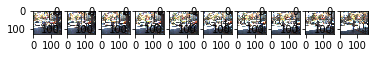

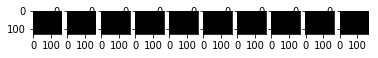

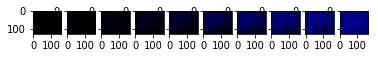

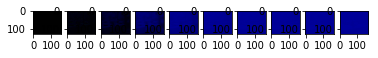

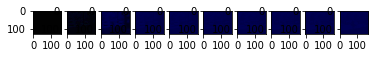

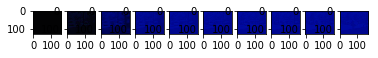

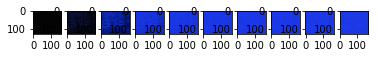

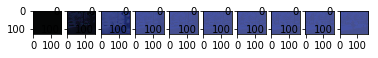

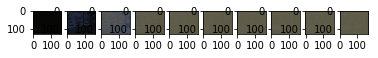

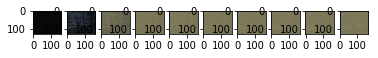

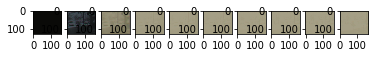

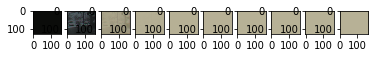

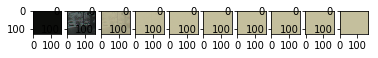

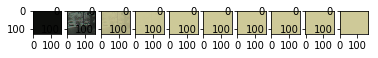

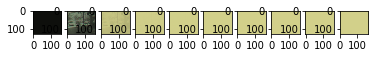

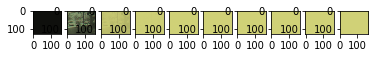

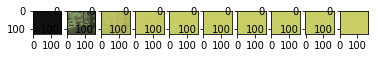

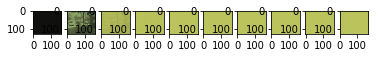

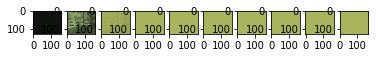

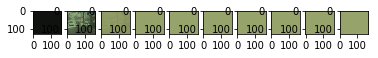

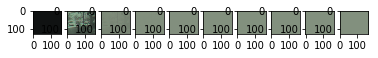

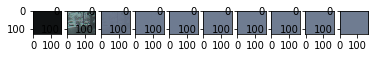

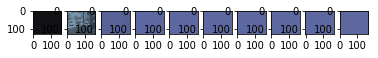

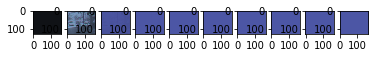

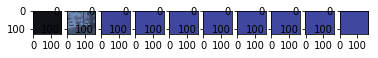

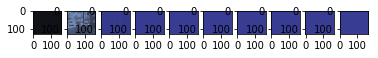

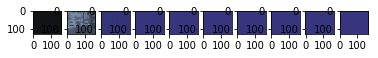

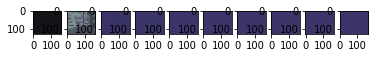

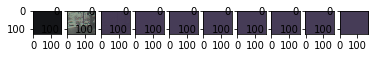

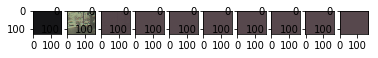

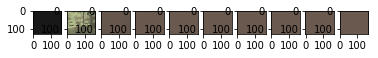

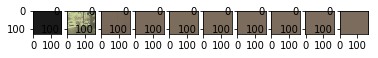

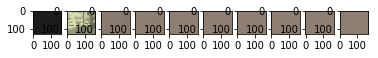

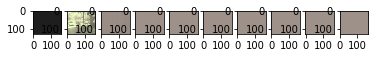

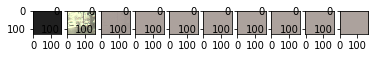

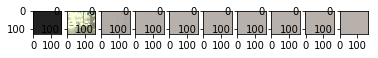

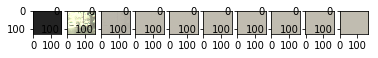

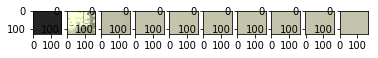

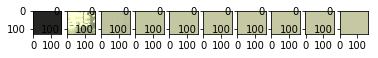

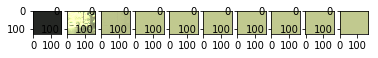

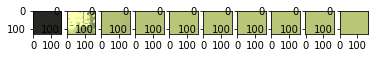

In [48]:
losses = train(loader, num_epochs, epoch_size, batch_size, scheduler, 
          prednet, loss_weights)

In [37]:
# ### Inspect parameters
# for param in prednet.parameters():
#     print( type(param.data), param.size(), param.requires_grad)
# state_dict = prednet.state_dict()
# for layer in state_dict.keys():
#     print(layer, state_dict[layer].size())
# #     print("\t{}".format(state_dict[layer]))


Text(0.5,0,'Iterations')

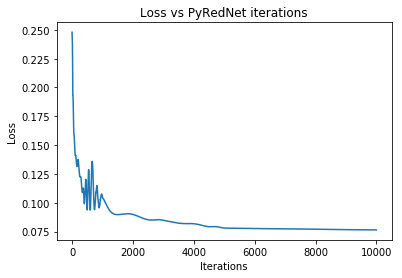

In [35]:
# Plot loss curve
plt.plot(losses)
plt.title("Loss vs PyRedNet iterations")
plt.ylabel("Loss")
plt.xlabel("Iterations")

In [ ]:
### Inference Mode ###
dataset = KittiDataset(val_file, val_source, nt, small=True)



In [ ]:
def hcatImg(data):
    numFrames = data.shape[0]
    f, ax = plt.subplots(1, numFrames)
    for i in range(numFrames):
        ax[i].axis("off")
        ax.plo